# Машинное обучение
## Домашнее задание №1: KNN + Линейные модели

**Срок сдачи:** 30 ноября 2021, 08:30 

**Максимально баллов:** 10 

**Штраф за опоздание:** по 2 балла за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла. Формат сдачи будет указан чуть позже.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -1 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 баллов

При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность.

## KNN (5 баллов)

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.metrics import accuracy_score, pairwise_distances
from scipy import stats
from scipy.spatial import distance
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold, cross_val_score
import warnings
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors


##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [167]:
class MyKNeighborsClassifier(BaseEstimator):
    def __init__(self, n_neighbors, algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        if self.algorithm == 'brute':
            self.X = X
            self.y = y
        elif self.algorithm == 'kd_tree':
            self.tree = KDTree(X)
            self.y = y
   
    def kneighbors(self, X):
        if self.algorithm == 'brute':
            neighbors = pairwise_distances(X=X, Y=self.X)
            k_ind = neighbors.argpartition(self.n_neighbors)
            k_ind = k_ind[:, :self.n_neighbors]
            k_dist = neighbors[:, k_ind]
        elif self.algorithm == 'kd_tree':
            k_dist, k_ind = self.tree.query(X, k=self.n_neighbors)
        return k_dist, k_ind

    def predict(self, X):
        X = X.astype(float)
        k_dist, k_ind = self.kneighbors(X)
        n_samples = X.shape[0]
        y_pred = np.zeros(X.shape[0], dtype=int)
        for idx, k in enumerate(k_ind):
            mode, _ = stats.mode(self.y[np.array(k)])
            y_pred[idx] = mode[0]
        return y_pred

'''    def predictv2(self, X):
        X = X.astype(float)
        neigh_dist, neigh_ind = self.kneighbors(X)
        classes_ = self.classes
        _y = self.y
        n_samples = X.shape[0]
        weights = np.ones_like(neigh_ind)
        all_rows = np.arange(X.shape[0])
        probabilities = []
        _y = self.y.reshape((-1, 1))
        classes_ = [self.classes]
        for k, classes_k in enumerate(classes_):
            pred_labels = _y[:, k][neigh_ind]
            proba_k = np.zeros((n_samples, classes_k.size))
            for i, idx in enumerate(pred_labels.T):
                proba_k[all_rows, idx] += weights[:, i]
            normalizer = proba_k.sum(axis=1)[:, np.newaxis]
            normalizer[normalizer == 0.0] = 1.0
            proba_k /= normalizer
            probabilities.append(proba_k)
        return probabilities'''
    
    def score(self, X, y):
        Y = self.predict(X)
        return np.mean(y == Y)

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [168]:
from sklearn.datasets import load_iris
iris = datasets.load_iris()

In [169]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [170]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [171]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [172]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    sklearn_pred = clf.predict(X_test)
    my_clf_pred = my_clf.predict(X_test)
    print(my_clf_pred)
    # vo [2 2 0 0 2 2 1 0 0 0 1 1 2 2 1]
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

[1 2 2 0 0 1 1 0 0 0 2 2 2 1 1]


In [173]:
abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )

0.0

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [174]:
%time clf.fit(X_train, y_train)

Wall time: 998 µs


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [175]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [176]:
with warnings.catch_warnings():  
    warnings.filterwarnings("ignore")
    sklearn_pred = clf.predict(X_test)
    %time clf.predict(X_test)
    %time my_clf.predict(X_test)

Wall time: 2.99 ms
Wall time: 3.99 ms


###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [177]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [178]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [179]:
%time clf.fit(X_train, y_train)

Wall time: 996 µs


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [180]:
%time my_clf.fit(X_train, y_train)

Wall time: 996 µs


In [183]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    sklearn_pred = clf.predict(X_test)
    %time clf.predict(X_test)
    %time my_clf.predict(X_test)

Wall time: 2.99 ms
Wall time: 4.98 ms


In [182]:
#with warnings.catch_warnings():
#    warnings.filterwarnings("ignore")
    

In [143]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    sklearn_pred = clf.predict(X_test)
    my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [301]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [302]:
data = newsgroups['data']
target = newsgroups['target']

In [303]:
#print(data[:1])
#print("target:",target[:100])

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [304]:
# Ограничиваем размер словаря
vocab_size = 10000
vectorize = CountVectorizer(input='content', analyzer='word', stop_words='english', max_features=vocab_size, max_df=0.95, min_df=2)
vectorize.fit(data)
vector = vectorize.transform(data)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [305]:
# Инициализация KFold с 3мя фолдами
kf = KFold(n_splits=3)
#kf.get_n_splits(data)
kf.split(data,target)
print(kf)
for train_index, test_index in kf.split(data):
    print("TRAIN:", train_index, "TEST:", test_index)


KFold(n_splits=3, random_state=None, shuffle=False)
TRAIN: [ 3772  3773  3774 ... 11311 11312 11313] TEST: [   0    1    2 ... 3769 3770 3771]
TRAIN: [    0     1     2 ... 11311 11312 11313] TEST: [3772 3773 3774 ... 7540 7541 7542]
TRAIN: [   0    1    2 ... 7540 7541 7542] TEST: [ 7543  7544  7545 ... 11311 11312 11313]


Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [ ]:
def bestKNN(k_range, vector, target, folds, metrica='minkowski'):
    k_scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k,metric=metrica)
        with warnings.catch_warnings():
            # Игнорируем предупреждения
            warnings.filterwarnings("ignore")
            scores = cross_val_score(knn, vector, target, cv=folds, scoring='accuracy')
        k_scores.append(scores.mean())
    return k_scores

def showScores(title,k_range,k_scores):
    plt.title(title)
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.show()
    index_min = k_range[min(range(len(k_scores)), key=k_scores.__getitem__)] 
    print("Best accuracy %.4f with %d neighbours." % (min(k_scores),index_min))

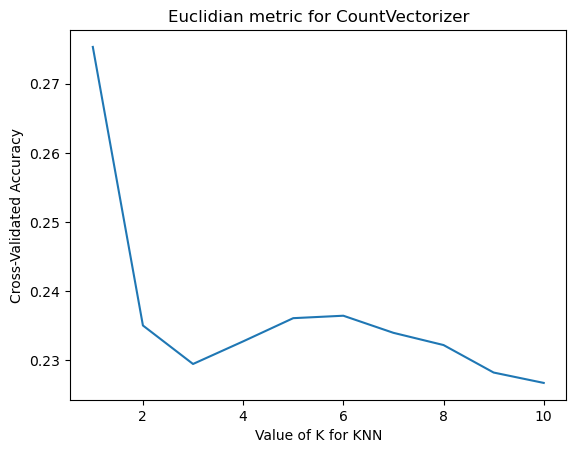

Best accuracy 0.2267 with 10 neighbours.


In [306]:
k_range = range(1,11)
k_scores = bestKNN(k_range, vector, target, 3)
showScores('Euclidian metric for CountVectorizer', k_range, k_scores)

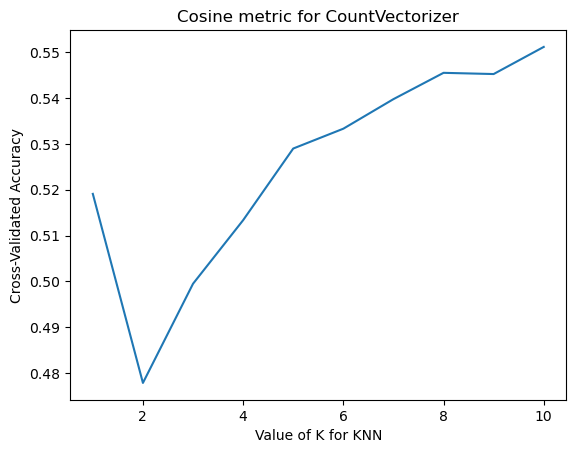

Best accuracy 0.4778 with 2 neighbours.


In [307]:
k_scores = bestKNN(k_range, vector, target, 3, 'cosine')
showScores('Cosine metric for CountVectorizer', k_range, k_scores)

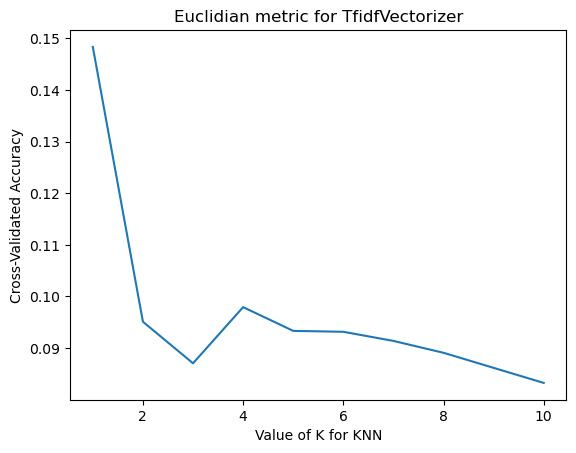

Best accuracy 0.0833 with 10 neighbours.


In [308]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(newsgroups.data)
y = newsgroups.target

k_scores = bestKNN(k_range, X, y, 3)
showScores('Euclidian metric for TfidfVectorizer', k_range, k_scores)

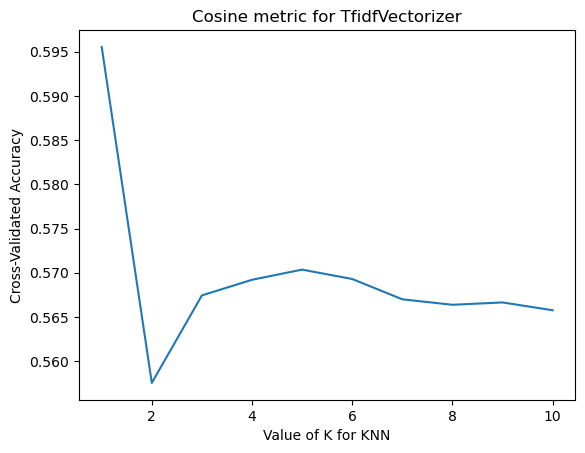

Best accuracy 0.5575 with 2 neighbours.


In [309]:
k_scores = bestKNN(k_range, X, y, 3, 'cosine')
showScores('Cosine metric for TfidfVectorizer', k_range, k_scores)

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [311]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

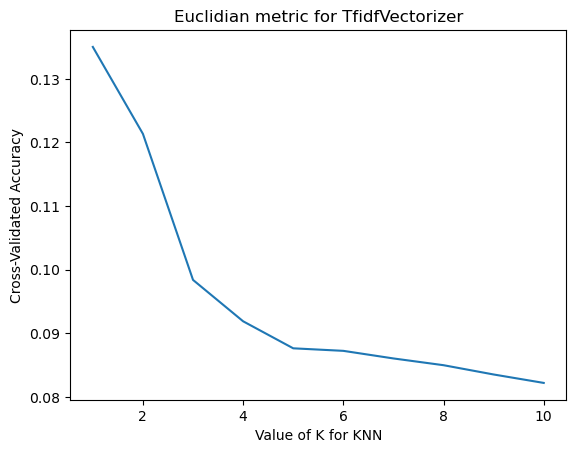

Best accuracy 0.0822 with 10 neighbours.


In [312]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(newsgroups.data)
y = newsgroups.target

k_scores = bestKNN(k_range, X, y, 3)
showScores('Euclidian metric for TfidfVectorizer', k_range, k_scores)

In [313]:
# Самая высокая точность на этом наборе данных получилась с TfidfVectorizer() на евклидовой метрике
# Cамая низкая - на том же TfidfVectorizer() на косинусной метрике (с косинусной метрикой лучше себя показал CountVectrorizer())
# Точность практически не отличается, вероятно, из-за размера данных и самого наполнения

# Линейные модели (5 баллов)

In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

### Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. 

Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [315]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    
    if shuffle:
        sample = np.random.permutation(np.arange(X.shape[0]))
        X = X[sample]
        y = y[sample]
    for i in range(y.shape[0] // batch_size):
        X_batch = X[i * batch_size : (i + 1) * batch_size]
        y_batch = y[i * batch_size : (i + 1) * batch_size]
        yield (X_batch, y_batch)

In [316]:
# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [317]:
#%%pycodestyle

def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    sigm_value_x = 1 / (1 + np.exp(-x))
    return sigm_value_x


from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, model_type='lin_reg', batch_size=1):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        self.batch_size = batch_size
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        
        if self.model_type == "lin_reg":
            reg = np.sum(self.weights ** 2) / self.C
            a = sigmoid(X_batch.dot(self.weights))
            N = X_batch.shape[0]
            loss = -(1 / N) * np.sum((y_batch - a) ** 2) + reg
            
        if self.model_type == "log_reg":
            reg = np.sum(self.weights ** 2) / self.C
            a = sigmoid(X_batch.dot(self.weights))
            N = X_batch.shape[0]
            loss = -(1 / N) * np.sum(y_batch * np.log(a + 1e-10) + (1 - y_batch) * np.log(1 - a + 1e-10)) + reg
      
        return loss
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
                                    
        if self.model_type == "lin_reg":
            reg = 2 * self.weights / self.C
            a = sigmoid(X_batch.dot(self.weights))
            N = X_batch.shape[0]
            loss_grad = (2 / N) * (a - y_batch).dot(X_batch) + reg
            
        if self.model_type == "log_reg":
            reg = 2 * self.weights / self.C
            a = sigmoid(X_batch.dot(self.weights))
            N = X_batch.shape[0]
            loss_grad = (1 / N) * (a - y_batch).dot(X_batch) + reg
        
        return loss_grad
    
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights -= self.alpha * new_grad

    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        
        # Нужно инициализровать случайно веса
        
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        self.weights = np.random.rand(X.shape[1])
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y) ##размер батча
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_loss = self.calc_loss(X_batch, y_batch)
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                # batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot 
      
       
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        if(self.model_type == 'lin_reg'):
            y_hat = np.dot(X, self.weights).astype(int)
        if(self.model_type == 'log_reg'):
            y_hat = (sigmoid(np.dot(X, self.weights)) > 0.5).astype(int)

        return y_hat

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [318]:
def plot_decision_boundary(clf, type_reg):
    x = np.linspace(-5, 9, num=2)
    plt.plot(x, -(clf.weights[0] + clf.weights[1] * x) / clf.weights[2], label=f'type = {type_reg}')
    

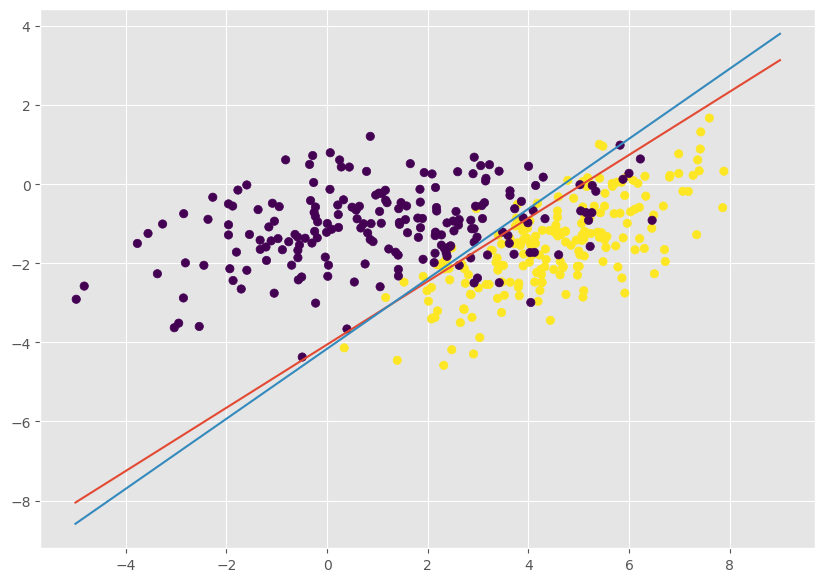

In [319]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

my_clf_lin = MySGDClassifier(batch_generator, C=10000, max_epoch=50, model_type="lin_reg")
my_clf_lin.fit(X, y)

my_clf_log = MySGDClassifier(batch_generator, C=10000, max_epoch=50, model_type="log_reg")
my_clf_log.fit(X, y)

plot_decision_boundary(my_clf_lin, 'lin_reg')
plot_decision_boundary(my_clf_log, 'log_reg')


plt.scatter(X[:,0], X[:,1], c=y)

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [320]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

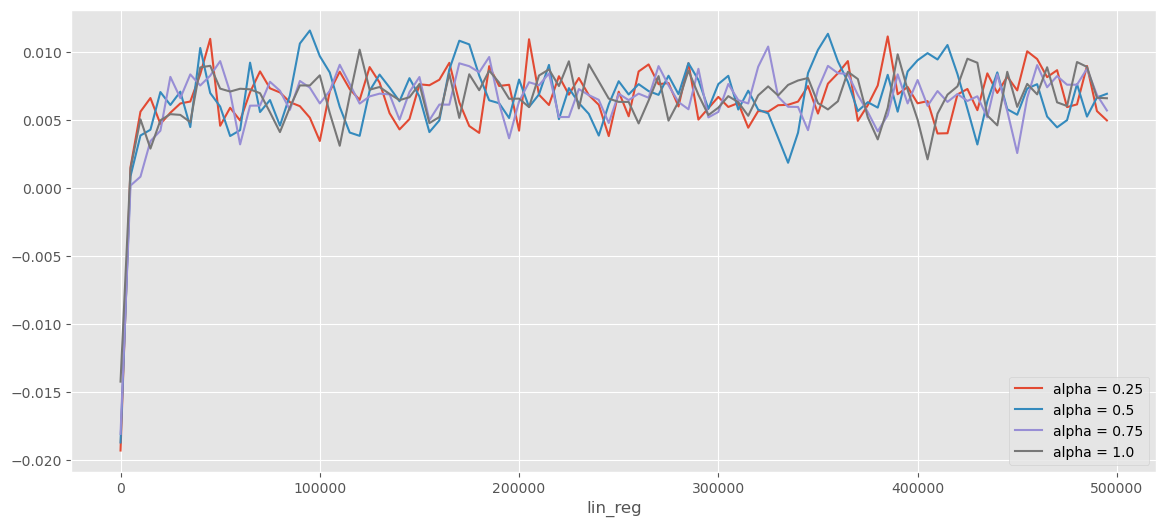

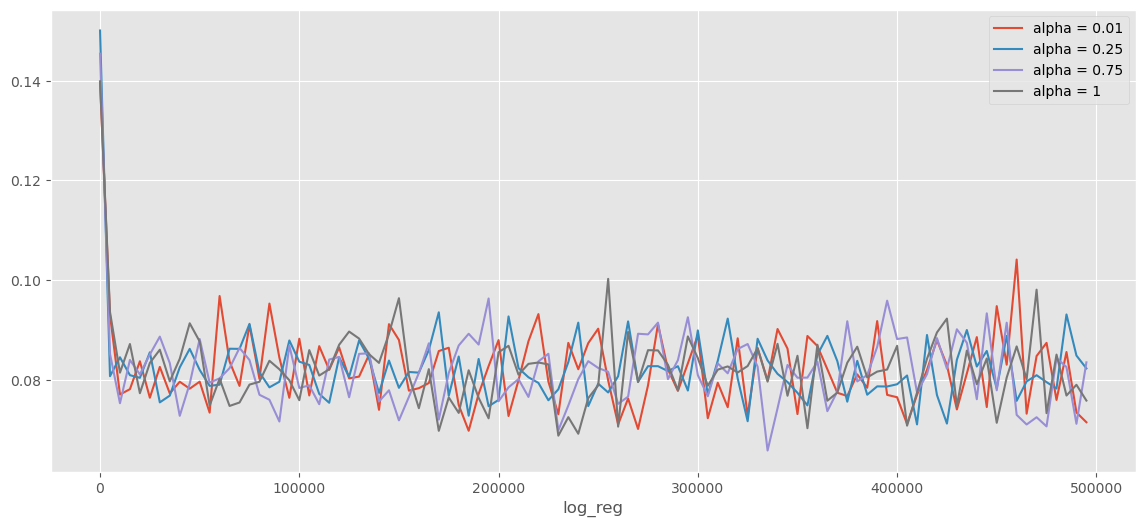

In [321]:
plt.figure(figsize=(14, 6))
N = 100
for alpha in [0.25, 0.5, 0.75, 1.0]:
    my_clf_lin = MySGDClassifier(batch_generator, C=1000, max_epoch=5, model_type="lin_reg")
    my_clf_lin.fit(X, y)
    means = np.mean(np.array_split(my_clf_lin.errors_log['loss'], N),axis=1)
    iters = np.array(np.array_split(np.arange(len(my_clf_lin.errors_log['iter'])), N))[:,0]
    plt.plot(iters, means, label=f'alpha = {alpha}')
plt.xlabel('lin_reg')
plt.legend()
plt.show()
    
plt.figure(figsize=(14, 6))
N = 100
for alpha in [0.01, 0.25, 0.75, 1]:
    my_clf_log = MySGDClassifier(batch_generator, C=1000, max_epoch=5, model_type="log_reg")
    my_clf_log.fit(X, y)
    means = np.mean(np.array_split(my_clf_log.errors_log['loss'], N),axis=1)
    iters = np.array(np.array_split(np.arange(len(my_clf_log.errors_log['iter'])), N))[:,0]
    plt.plot(iters, means, label=f'alpha = {alpha}')
    
plt.xlabel('log_reg')
plt.legend()
plt.show()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

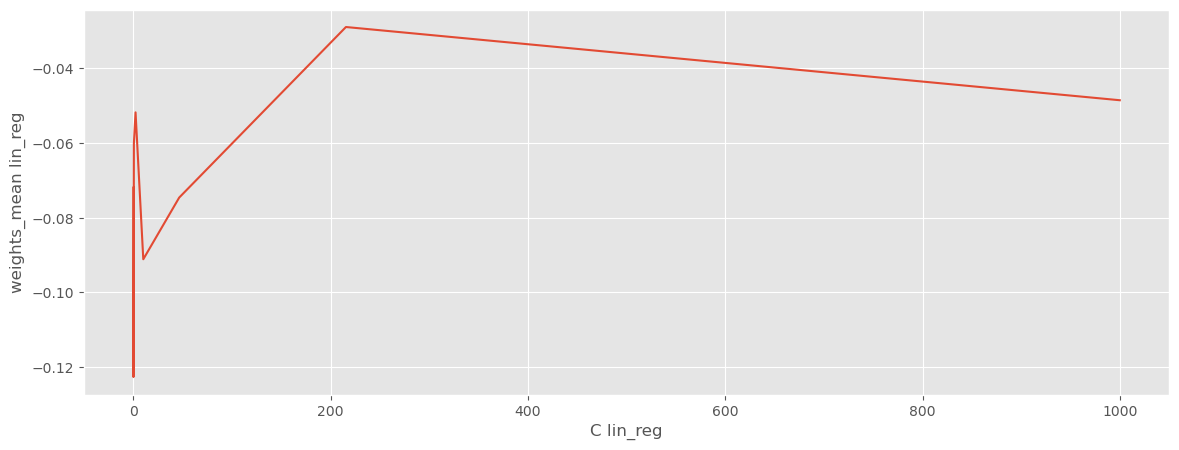

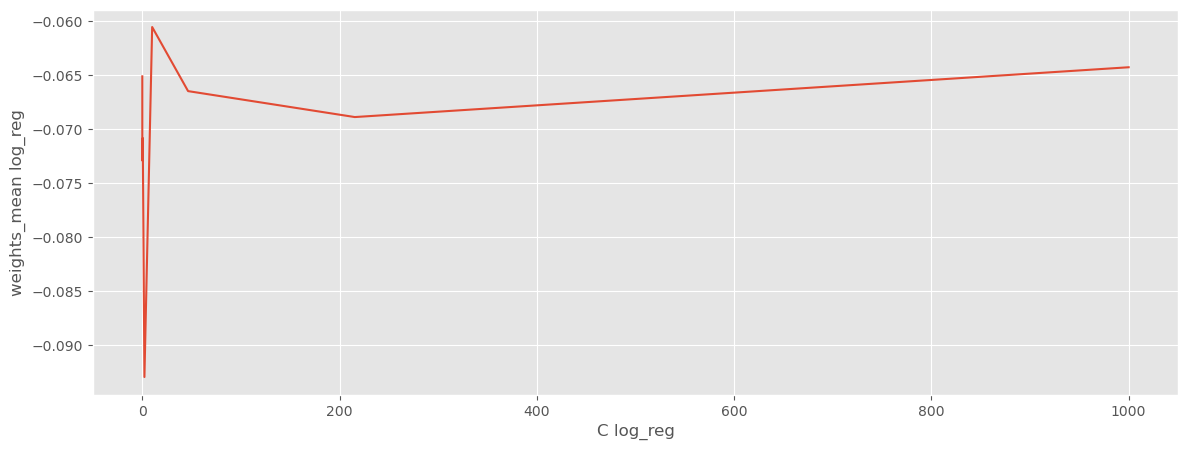

In [322]:
plt.figure(figsize=(14, 5))
weights_mean = np.zeros(np.logspace(3, -3, 10).shape)

for i, C in enumerate(np.logspace(3, -3, 10)):
    my_clf_lin = MySGDClassifier(batch_generator, C=1000, max_epoch=5, model_type="lin_reg")
    my_clf_lin.fit(X, y)
    weights_mean[i] = my_clf_lin.weights.mean()
    
plt.plot(np.logspace(3, -3, 10), weights_mean)
plt.xlabel('C lin_reg')
plt.ylabel('weights_mean lin_reg')
plt.show()

plt.figure(figsize=(14, 5))
weights_mean = np.zeros(np.logspace(3, -3, 10).shape)

for i, C in enumerate(np.logspace(3, -3, 10)):
    my_clf_log = MySGDClassifier(batch_generator, C=1000, max_epoch=5, model_type="log_reg")
    my_clf_log.fit(X, y)
    weights_mean[i] = my_clf_log.weights.mean()
    
plt.plot(np.logspace(3, -3, 10), weights_mean)
plt.xlabel('C log_reg')
plt.ylabel('weights_mean log_reg')
plt.show()

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

In [323]:
#Да